In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
import pandas as pd
from scipy.optimize import bisect
from scipy.optimize import root_scalar

In [6]:
def I(sigma, S_0 = 100 , K = 120, r = 0.05, T = 0.2):
    """Closed form solution of an european put option of a geometric brownian motion with equidistant time steps adjusted to the market price
    Parameters
    ----------
    sigma : float
        volatility of the geometric brownian motion
    I_market : float
        Market price of such put options
    S_0 : float
        Initial value of the geometric brownian motion
    K : float
        strike price of the put option
    r : float
        interest rate of the put option
    sigma : float
        volatility of the geometric brownian motion
    T : float
        time horizon of the put option

    Returns
    -------
    I : float
        Mark to market price of the put option"""
    
    w = (np.log(K/S_0) - (r-0.5*sigma**2)*T) / ( sigma * np.sqrt(T) )
    I = np.exp(-r*T) * K * st.norm.cdf(w) - S_0 * st.norm.cdf(w - sigma*np.sqrt(T))
    return I

def Simulate_Stock_Price(S_0,sigma, r, T, m,N):
    """This function returns N GBM, each evaluated at time T/m,...,T where they each start at  s_0

    Parameters
    ----------
    s_0 : float
        Initial value of the geometric Brownian motion
    sigma : float
        Volatility of the geometric Brownian motion
    r : float
        Interest rate of the geometric Brownian motion
    t : float
        Time horizon of the geometric Brownian motion
    N : int
        Number of GBM to generate

    Returns
    -------
    S : np.ndarray
        N GBM evaluated at time T/m,...,T (N_features, m_features)
    """
    simulations = np.ndarray((N, m))
    expXt = st.lognorm.rvs(s=np.sqrt(sigma ** 2 * T / m), loc=0, scale=np.exp((r - 0.5 * sigma ** 2) * T / m), size=m*N)
    expXt_reshaped = expXt.reshape((N, m), order='F')  # Reshape the array to m rows and N columns
    simulations = np.cumprod(np.concatenate([np.ones((N, 1)) * S_0, expXt_reshaped], axis=1), axis=1)
    return simulations[:, 1:]

def RM_European(n, N, rho, K, S0, T, r, I_market):
    sigma_0 = 1
    alpha_0 = 2/(K+S0)

    sigma_estim = np.empty((n,))
    sigma_estim[0] = sigma_0
    
    for i in range(1, n):
        alpha_n = alpha_0 / i ** rho
        sigma_cur = sigma_estim[i - 1]

        # Compute Jhat
        stock_prices = Simulate_Stock_Price(S0, sigma_cur, r, T, m=1, N=N)
        payoffs = np.exp(-r*T) * np.maximum(K - stock_prices, 0)
        Jhat = np.mean(payoffs) - I_market

        sigma_estim[i] = sigma_cur - alpha_n * Jhat

    return sigma_estim

Question 1: Retrieve trued volatility 

In [6]:
I_m = 22
sigma_opt = bisect(lambda sigma: I(sigma) - I_m, 0.01, 10)
print(sigma_opt)
print()
print(f" The sigma optimal for Imarket = {I_m} is sigma_opt = {sigma_opt}")
print()
print(f" This is a pretty good approximation since with this sigma_opt we obtain that I(sigma_opt) = {I(sigma_opt)}")

0.508372926009589

 The sigma optimal for Imarket = 22 is sigma_opt = 0.508372926009589

 This is a pretty good approximation since with this sigma_opt we obtain that I(sigma_opt) = 21.999999999986855


Question 2: RM algorithm to obtain the volatility

Apply RM Algorithm to find the implied volality. Estimation of the Mean Squared Error (MSE).

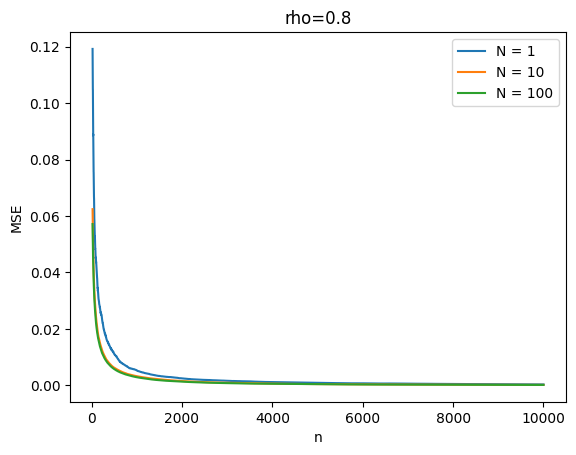

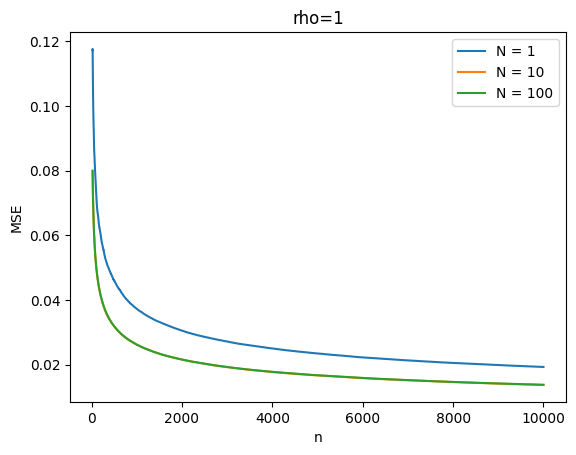

In [8]:
n = 10000
iterations = 100
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
for rho in [0.8,1]:
    plt.figure()
    plt.title('rho=' + str(rho))
    for N in [1,10,100]:
        # Estimate expectation of MSE
        all_sigma_estim = np.empty((iterations,), dtype=np.ndarray)
        for i in range(iterations):
            all_sigma_estim[i] = RM_European(n, N, rho, K, S0, T, r, I_market)
        MSE = np.mean((all_sigma_estim - sigma_opt)**2, axis=0)

        plt.plot(np.arange(21, n+1), MSE[20:], label='N = ' + str(N))
    plt.legend()
    plt.xlabel('n')
    plt.ylabel('MSE')

Part 2: Asian Option 

In [9]:
def RM_Asian(n, N, rho, K, S0, T, r, I_market, m, sigma_0=1):
    """ Crude MonteCarlo estimator for Robin_Monro algorithm
    Parameters
    ----------
    sigma : float
        volatility of the geometric brownian motion
    N : int
        Size of the sample size for the estimation of the expected value
    K : float
        strike price of the put option
    S_0 : float
        Initial value of the geometric brownian motion
    r : float
        interest rate of the put option
    T : float
        time horizon of the put option
    I_market : float
        consistent mark to market price of the put option
    m : int
        number of time steps
    
    Returns
    -------
    J : float
        Crude MonteCarlo estimator of the the expected value of the payoff of the put option"""

    alpha_0 = 2/(K+S0)

    sigma_estim = np.empty((n,))
    sigma_estim[0] = sigma_0
    
    for i in range(1, n):
        alpha_n = alpha_0 / i ** rho
        sigma_cur = sigma_estim[i - 1]

        # Calculate Jhat
        simulations = Simulate_Stock_Price(S0, sigma_cur, r, T, m, N)
        avg_stock_prices = np.mean(simulations, axis=1)
        payoffs = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0)
        Jhat = np.mean(payoffs) - I_market
        
        sigma_estim[i] = sigma_cur - alpha_n * Jhat

    return sigma_estim

Question 5: Find optimal volatility 

pho:

The first plot shows that it might not converge for pho = 1, and pho = 0.5 is way more aggressive, it will penalize less the higher n values terms 

Text(0, 0.5, 'sigma')

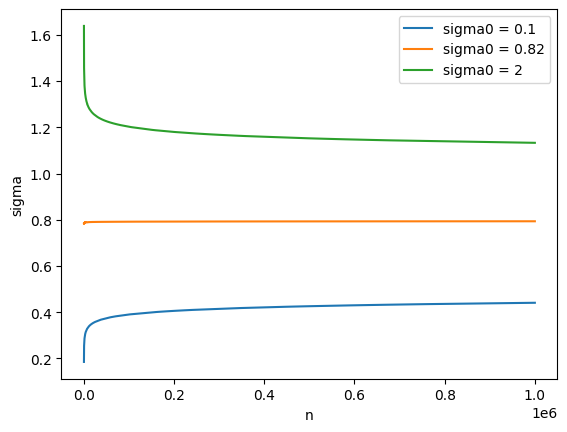

In [36]:
n = 1000000
N = 100
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
sigma0 = [0.1,0.82,2]

# Take off the first 20 values
for i in range(len(sigma0)):
    sigmas = RM_Asian(n, N, rho=1, K=K, S0=S0, T=T, r=r, I_market=I_market, m=30,sigma_0=sigma0[i])
    plt.plot(range(21,n+1), sigmas[20:], label='sigma0 = ' + str(sigma0[i]))

plt.legend()
plt.xlabel('n')
plt.ylabel('sigma')

Text(0, 0.5, 'sigma')

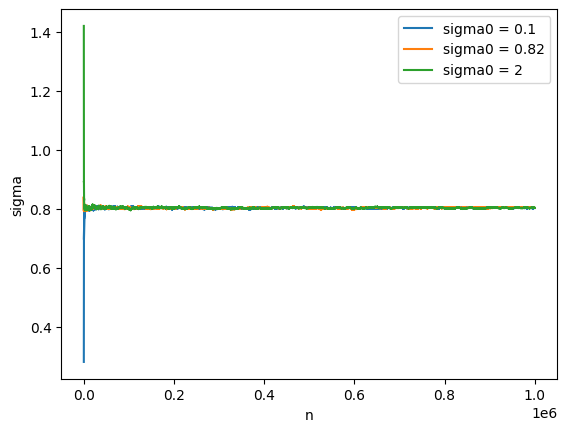

In [37]:
n = 1000000
N = 100
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
sigma0 = [0.1,0.82,2]

# Take off the first 20 values
for i in range(len(sigma0)):
    sigmas = RM_Asian(n, N, rho=0.5, K=K, S0=S0, T=T, r=r, I_market=I_market, m=30,sigma_0=sigma0[i])
    plt.plot(range(21,n+1), sigmas[20:], label='sigma0 = ' + str(sigma0[i]))

plt.legend()
plt.xlabel('n')
plt.ylabel('sigma')

Text(0, 0.5, 'sigma')

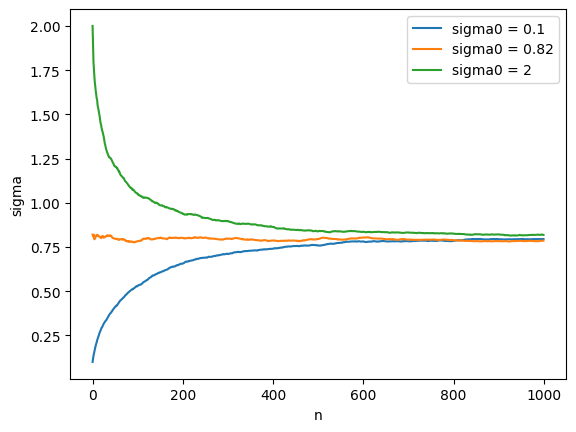

In [41]:
n = 1000
N = 100
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
sigma0 = [0.1,0.82,2]

# Take off the first 20 values
for i in range(len(sigma0)):
    sigmas = RM_Asian(n, N, rho=0.5, K=K, S0=S0, T=T, r=r, I_market=I_market, m=30,sigma_0=sigma0[i])
    plt.plot(range(0,n), sigmas, label='sigma0 = ' + str(sigma0[i]))

plt.legend()
plt.xlabel('n')
plt.ylabel('sigma')

Text(0, 0.5, 'sigma')

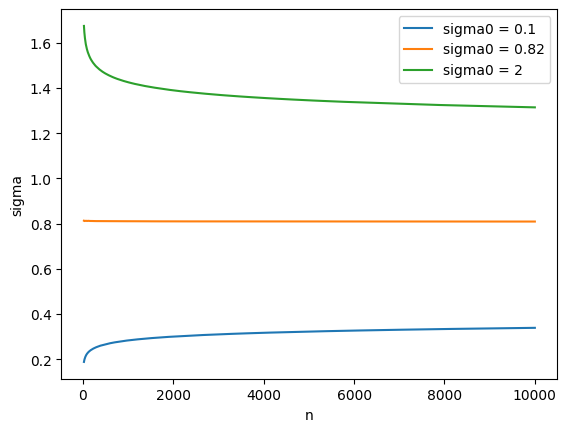

In [43]:
n = 10000
N = 1000
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
sigma0 = [0.1,0.82,2]

# Take off the first 20 values
for i in range(len(sigma0)):
    sigmas = RM_Asian(n, N, rho=1, K=K, S0=S0, T=T, r=r, I_market=I_market, m=30,sigma_0=sigma0[i])
    plt.plot(range(21,n+1), sigmas[20:], label='sigma0 = ' + str(sigma0[i]))

plt.legend()
plt.xlabel('n')
plt.ylabel('sigma')

We will try to understand the variance of Z as a function of sigma

Answer: Its like -x^2, therefore if we overshoot the Robin Monro algorithm will keep giving smaller sigma values until it converges. 
Therefore we can implement a sort of two stages MC who uses a N such that at each stage of the iteration the variance is smaller than a certain threshold.

Text(0.5, 1.0, 'Variance of J estimator/Z as a function of sigma')

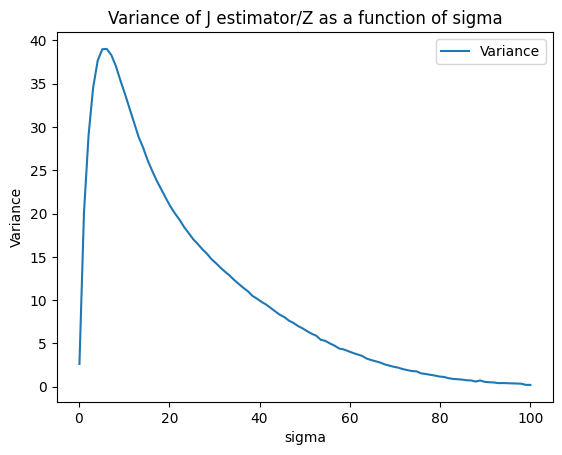

In [68]:
N = 1000000
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22

sigma = np.linspace(0.1, 100, 100)
sdev = np.zeros(shape=(len(sigma),))

for i in range(len(sigma)):
    simulations = Simulate_Stock_Price(S0, sigma[i], r, T, m=30, N=N)
    avg_stock_prices = np.mean(simulations, axis=1)
    Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
    sdev[i] = np.std(Z)

plt.plot(sigma, sdev, label='Variance')
plt.legend()
plt.xlabel('sigma')
plt.ylabel('standard deviation')
plt.title('standard deviation of J estimator/Z as a function of sigma')


Text(0.5, 1.0, 'standard deviation of J estimator/Z as a function of sigma')

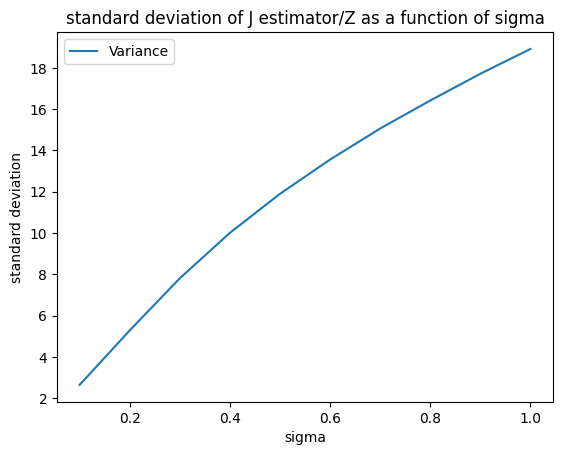

In [71]:
N = 1000000
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22

sigma = np.linspace(0.1, 1, 10)
sdev = np.zeros(shape=(len(sigma),))

for i in range(len(sigma)):
    simulations = Simulate_Stock_Price(S0, sigma[i], r, T, m=30, N=N)
    avg_stock_prices = np.mean(simulations, axis=1)
    Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
    sdev[i] = np.std(Z)

plt.plot(sigma, sdev, label='Variance')
plt.legend()
plt.xlabel('sigma')
plt.ylabel('standard deviation')
plt.title('standard deviation of J estimator/Z as a function of sigma')

We will plot the mean and the standard deviation of J as a function of N

Text(0.5, 1.0, 'standard deviation of J estimator/Z as a function of N')

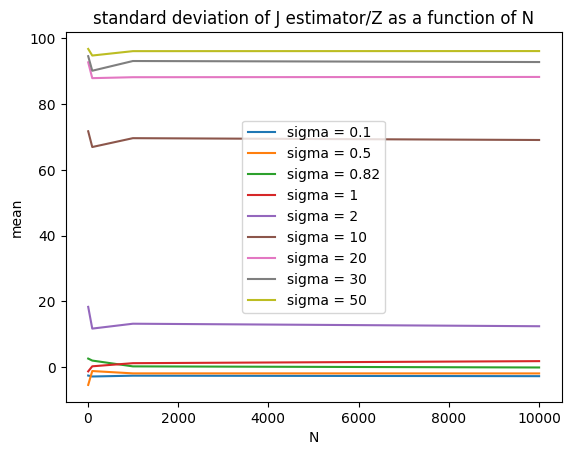

In [88]:
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
sigma = [0.1,0.5,0.82,1,2,10,20,30,50]
N = [10,100,1000,10000]

mean = np.zeros(shape=(len(N),len(sigma)))
sdev = np.zeros(shape=(len(N),len(sigma)))

for i in range(len(N)):
    for j in range(len(sigma)):
        simulations = Simulate_Stock_Price(S0, sigma[j], r, T, m=30, N=N[i])
        avg_stock_prices = np.mean(simulations, axis=1)
        Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
        mean[i,j] = np.mean(Z)
        sdev[i,j] = np.std(Z)

for i in range(len(sigma)):
    plt.plot(N, mean[:,i], label='sigma = ' + str(sigma[i]))
plt.legend()
plt.xlabel('N')
plt.ylabel('mean')
plt.title('Mean of J estimator/Z as a function of N')

In [99]:
N = 1000000
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22

sigma = 0.82 

simulations = Simulate_Stock_Price(S0, sigma , r, T, m=30, N=N)
avg_stock_prices = np.mean(simulations, axis=1)
Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
St_dev= np.std(Z)

print(f"standard deviation around sigma = {sigma} is {St_dev}")
print(f"Using a CLT confidence interval of 95% we obtain that we need {int((1.96*St_dev )**2)} simulations to have a 95% confidence interval of length 1 for sigma = {sigma}")
sigma = 2

simulations = Simulate_Stock_Price(S0, sigma , r, T, m=30, N=N)
avg_stock_prices = np.mean(simulations, axis=1)
Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
St_dev= np.std(Z)


print(f"standard deviation around sigma={sigma}  is {St_dev}")
print(f"Using a CLT confidence interval of 95% we obtain that we need {int((1.96*St_dev )**2)} simulations to have a 95% confidence interval of length 1 for sigma = {sigma}")

standard deviation around sigma = 0.82 is 16.68119992424884
Using a CLT confidence interval of 95% we obtain that we need 1068 simulations to have a 95% confidence interval of length 1 for sigma = 0.82
standard deviation around sigma=2  is 28.201336330104713
Using a CLT confidence interval of 95% we obtain that we need 3055 simulations to have a 95% confidence interval of length 1 for sigma = 2


With our values N=1000, m=50

In [36]:
N = 1000
m = 50
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22

sigma = 0.82 

simulations = Simulate_Stock_Price(S0, sigma , r, T, m=m, N=N)
avg_stock_prices = np.mean(simulations, axis=1)
Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
St_dev= np.std(Z)

print(f"standard deviation around sigma = {sigma} is {St_dev}")
print(f"Using a CLT confidence interval of 95% we obtain that we need {int((1.96*St_dev )**2)} simulations to have a 95% confidence interval of length 1 for sigma = {sigma}")
sigma = 2

simulations = Simulate_Stock_Price(S0, sigma , r, T, m=30, N=N)
avg_stock_prices = np.mean(simulations, axis=1)
Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
St_dev= np.std(Z)


print(f"standard deviation around sigma={sigma}  is {St_dev}")
print(f"Using a CLT confidence interval of 95% we obtain that we need {int((1.96*St_dev )**2)} simulations to have a 95% confidence interval of length 1 for sigma = {sigma}")

standard deviation around sigma = 0.82 is 16.563839996297034
Using a CLT confidence interval of 95% we obtain that we need 1053 simulations to have a 95% confidence interval of length 1 for sigma = 0.82
standard deviation around sigma=2  is 28.042518787987447
Using a CLT confidence interval of 95% we obtain that we need 3020 simulations to have a 95% confidence interval of length 1 for sigma = 2


Thats just theoritical when N is extremely large, since its lognormal the approximation is horrendous

Actually it undershoots the real standard deviation of Z, as we can see when N increases, the value increases

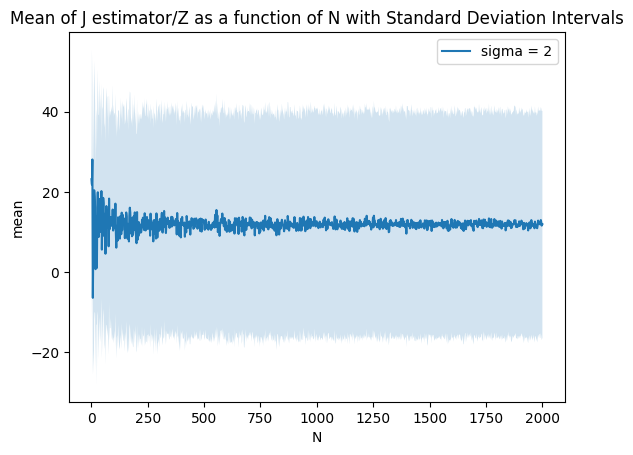

In [121]:
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
sigma = [2]
N = np.linspace(1, 2000, 1000).astype(int)

mean = np.zeros(shape=(len(N),len(sigma)))
sdev = np.zeros(shape=(len(N),len(sigma)))

for i in range(len(N)):
    for j in range(len(sigma)):
        simulations = Simulate_Stock_Price(S0, sigma[j], r, T, m=30, N=N[i])
        avg_stock_prices = np.mean(simulations, axis=1)
        Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
        mean[i,j] = np.mean(Z)
        sdev[i,j] = np.std(Z)

# Plotting
for i in range(len(sigma)):
    plt.plot(N, mean[:,i], label='sigma = ' + str(sigma[i]))
    plt.fill_between(N, mean[:,i] - sdev[:,i], mean[:,i] + sdev[:,i], alpha=0.2)

plt.legend()
plt.xlabel('N')
plt.ylabel('mean')
plt.title('Mean of J estimator/Z as a function of N with Standard Deviation Intervals')
plt.show()

Text(0.5, 1.0, 'Standard Deviation as a function of N')

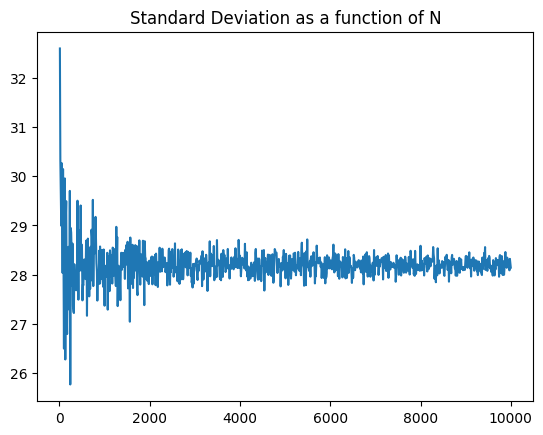

In [120]:
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
sigma = [2]
N = np.linspace(10, 10000, 1000).astype(int)

mean = np.zeros(shape=(len(N),len(sigma)))
sdev = np.zeros(shape=(len(N),len(sigma)))

for i in range(len(N)):
    for j in range(len(sigma)):
        simulations = Simulate_Stock_Price(S0, sigma[j], r, T, m=30, N=N[i])
        avg_stock_prices = np.mean(simulations, axis=1)
        Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
        mean[i,j] = np.mean(Z)
        sdev[i,j] = np.std(Z)


plt.plot(N, sdev[:,0])
plt.title("Standard Deviation as a function of N")

Text(0.5, 1.0, 'Standard Deviation as a function of N')

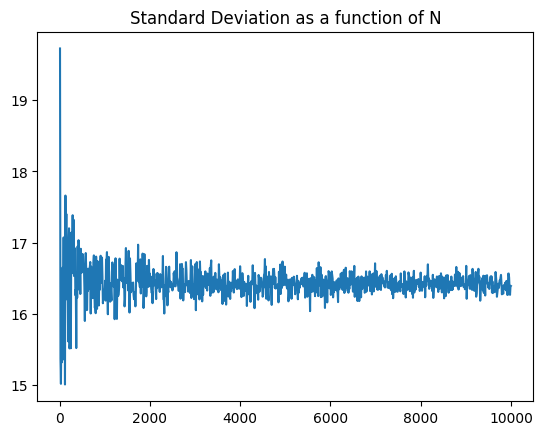

In [30]:
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
sigma = [0.8]
N = np.linspace(10, 10000, 1000).astype(int)

mean = np.zeros(shape=(len(N),len(sigma)))
sdev = np.zeros(shape=(len(N),len(sigma)))

for i in range(len(N)):
    for j in range(len(sigma)):
        simulations = Simulate_Stock_Price(S0, sigma[j], r, T, m=30, N=N[i])
        avg_stock_prices = np.mean(simulations, axis=1)
        Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
        mean[i,j] = np.mean(Z)
        sdev[i,j] = np.std(Z)


plt.plot(N, sdev[:,0])
plt.title("Standard Deviation as a function of N")

We will try to understand why the first plot didnt converge for pho = 1

In [3]:
def RM_Asian_mean_sd(n, N, rho, K, S0, T, r, I_market, m, sigma_0=1):
    """ Crude MonteCarlo estimator for Robin_Monro algorithm
    Parameters
    ----------
    sigma : float
        volatility of the geometric brownian motion
    N : int
        Size of the sample size for the estimation of the expected value
    K : float
        strike price of the put option
    S_0 : float
        Initial value of the geometric brownian motion
    r : float
        interest rate of the put option
    T : float
        time horizon of the put option
    I_market : float
        consistent mark to market price of the put option
    m : int
        number of time steps
    
    Returns
    -------
    J : float
        Crude MonteCarlo estimator of the the expected value of the payoff of the put option"""

    alpha_0 = 2/(K+S0)
    tol = 1 

    sigma_estim = np.empty((n,))
    mean_it = np.empty((n,))
    sd_it = np.empty((n,))

    sigma_estim[0] = sigma_0
    
    simulations = Simulate_Stock_Price(S0, sigma_0 , r, T, m, N)
    avg_stock_prices = np.mean(simulations, axis=1)
    Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
    mean_it[0] = np.mean(Z)
    sd_it[0] = np.std(Z)


    for i in range(1, n):
        alpha_n = alpha_0 / i ** rho
        sigma_cur = sigma_estim[i - 1]

        # Calculate Jhat
        simulations = Simulate_Stock_Price(S0, sigma_cur, r, T, m, N)
        avg_stock_prices = np.mean(simulations, axis=1)
        payoffs = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0)
        Jhat = np.mean(payoffs) - I_market
        
        sigma_estim[i] = sigma_cur - alpha_n * Jhat

        mean_it[i] = Jhat
        sd_it[i] = np.std(simulations)


    return sigma_estim,mean_it,sd_it

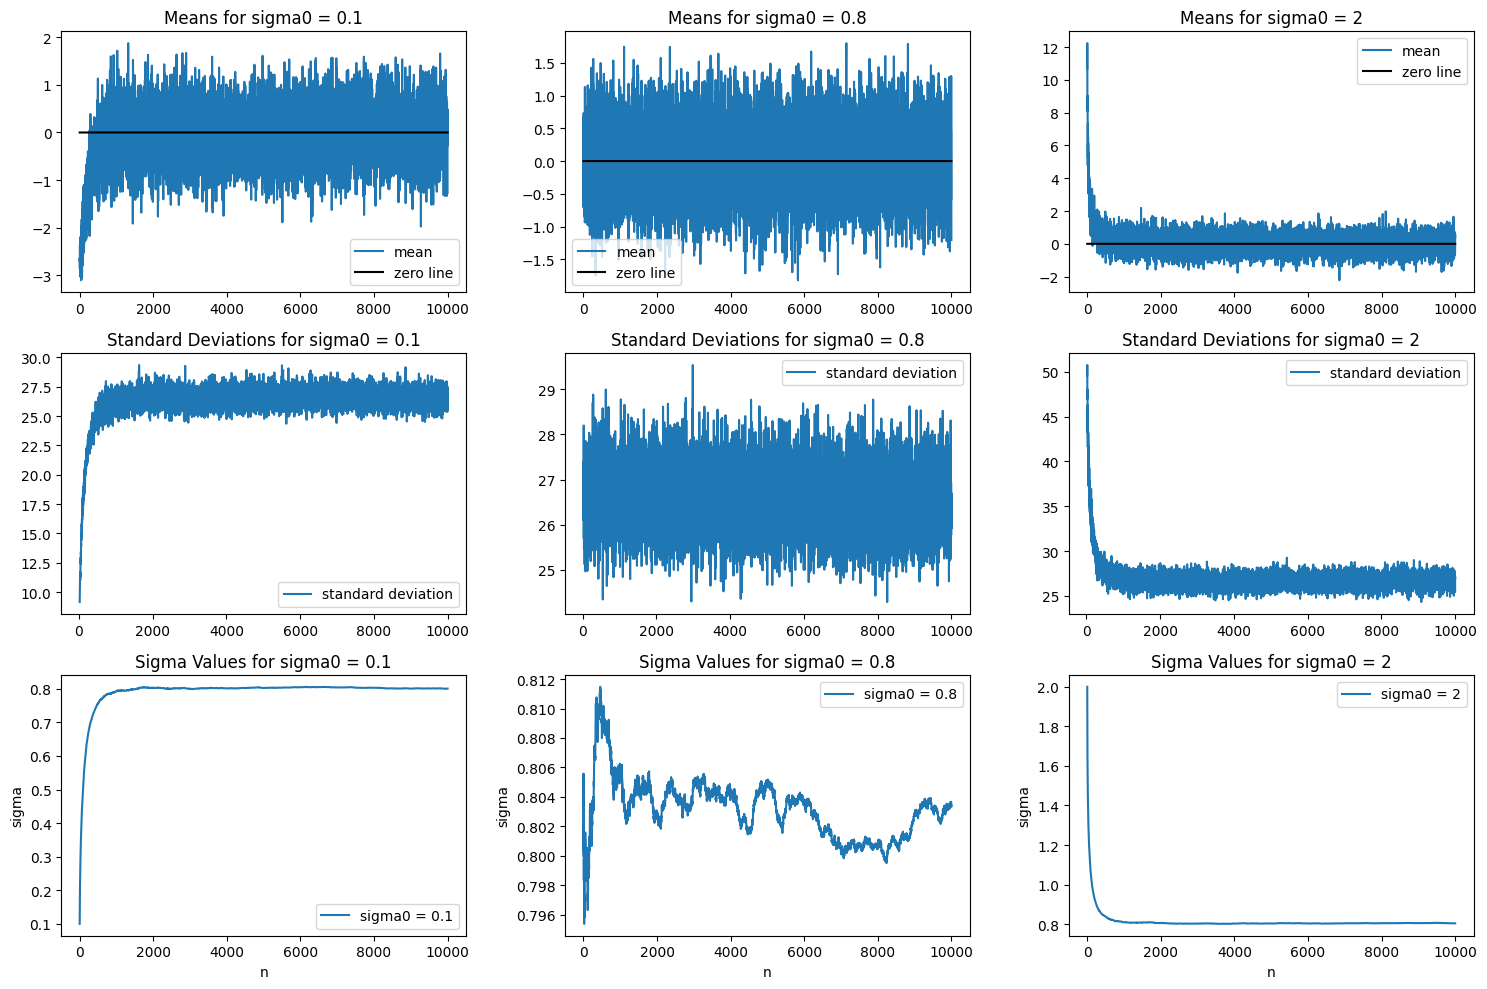

In [95]:
n = 10000
N = 1000
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
sigma0_values = [0.1,0.8,2]


# Creating a 3x3 grid of plots
fig, axs = plt.subplots(3, 3, figsize=(15, 10))  # 3 rows, 3 columns

for i, sigma0 in enumerate(sigma0_values):
    
    sigmas,means,sds = RM_Asian_mean_sd(n, N, rho=0.5, K=K, S0=S0, T=T, r=r, I_market=I_market, m=30,sigma_0 = sigma0)

    # Plotting means in the first column
    axs[0, i].plot(means, label='mean')
    axs[0, i].plot(np.zeros(shape=(n,)),color='black',label='zero line')
    axs[0, i].set_title(f'Means for sigma0 = {sigma0}')
    axs[0, i].legend()

    # Plotting standard deviations (excluding first 20 values) in the second column
    axs[1, i].plot(range(21, n+1), sds[20:], label='standard deviation')
    axs[1, i].set_title(f'Standard Deviations for sigma0 = {sigma0}')
    axs[1, i].legend()

    # Plotting sigma values in the third column
    axs[2, i].plot(range(n), sigmas, label=f'sigma0 = {sigma0}')
    axs[2, i].set_title(f'Sigma Values for sigma0 = {sigma0}')
    axs[2, i].legend()
    axs[2, i].set_xlabel('n')
    axs[2, i].set_ylabel('sigma')

plt.tight_layout()
plt.show()


Drop first 2000 values (Burn in period)

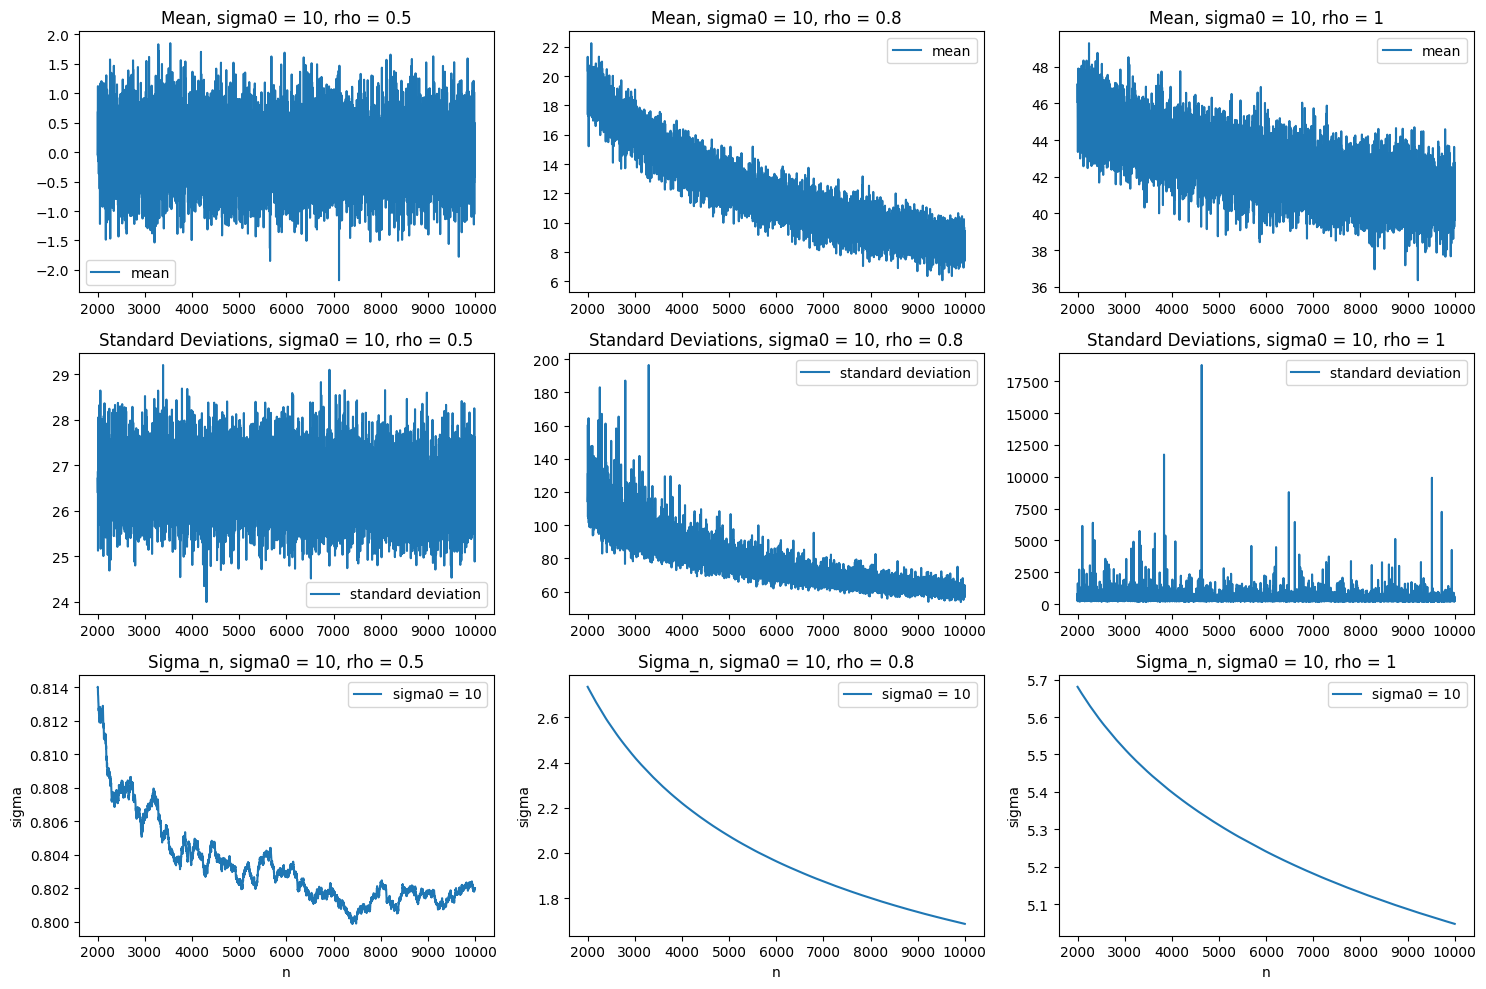

In [74]:
n = 10000
N = 1000
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
sigma0 = 10
rho_values = [0.5,0.8,1]


# Creating a 3x3 grid of plots
fig, axs = plt.subplots(3, 3, figsize=(15, 10))  # 3 rows, 3 columns

for i, rho in enumerate(rho_values):
    
    sigmas,means,sds = RM_Asian_mean_sd(n, N, rho= rho, K=K, S0=S0, T=T, r=r, I_market=I_market, m=30,sigma_0 = sigma0)

    # Plotting means in the first column
    axs[0, i].plot(range(n), means, label='mean')
    axs[0, i].set_title(f'Mean, sigma0 = {sigma0}, rho = {rho}')
    axs[0, i].legend()

    # Plotting standard deviations (excluding first 20 values) in the second column
    axs[1, i].plot(range(n), sds, label='standard deviation')
    axs[1, i].set_title(f'Standard Deviations, sigma0 = {sigma0}, rho = {rho}')
    axs[1, i].legend()

    # Plotting sigma values in the third column
    axs[2, i].plot(range(n), sigmas, label=f'sigma0 = {sigma0}')
    axs[2, i].set_title(f'Sigma_n, sigma0 = {sigma0}, rho = {rho}')
    axs[2, i].legend()
    axs[2, i].set_xlabel('n')
    axs[2, i].set_ylabel('sigma')

plt.tight_layout()
plt.show()

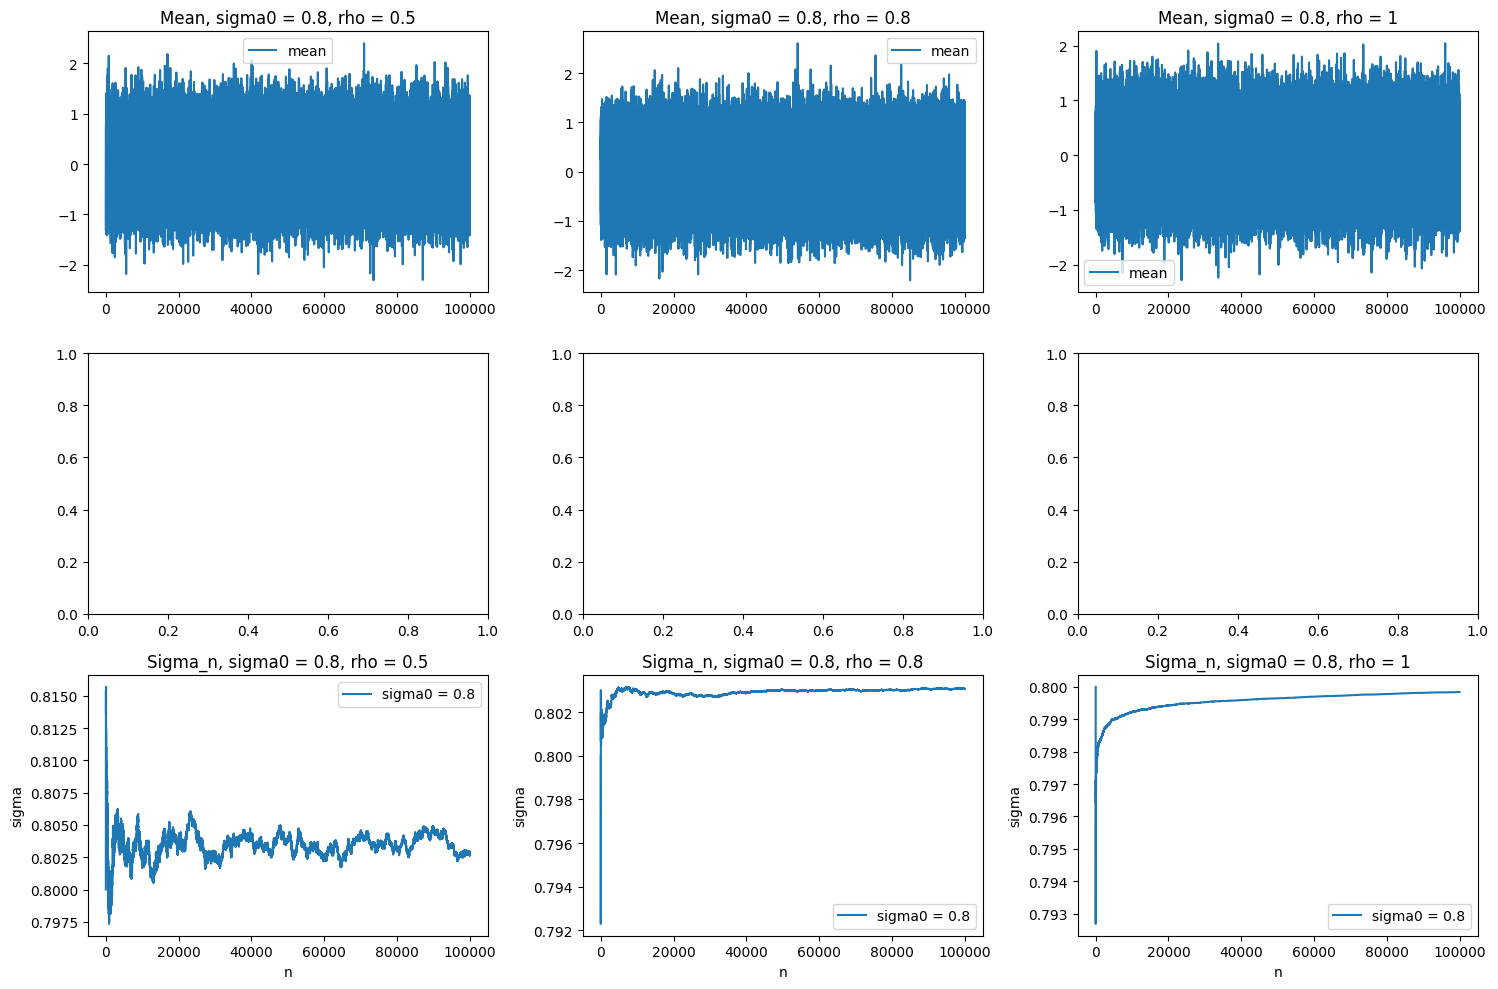

In [89]:
n = 10000
N = 1000
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
sigma0 = 0.8
rho_values = [0.5,0.8,1]


# Creating a 3x3 grid of plots
fig, axs = plt.subplots(3, 2, figsize=(15, 10))  # 3 rows, 3 columns

for i, rho in enumerate(rho_values):
    
    sigmas,means,sds = RM_Asian_mean_sd(n, N, rho= rho, K=K, S0=S0, T=T, r=r, I_market=I_market, m=30,sigma_0 = sigma0)

    # Plotting means in the first column
    axs[0, i].plot(range(n), means, label='mean')
    axs[0, i].set_title(f'Mean, sigma0 = {sigma0}, rho = {rho}')
    axs[0, i].legend()

    # Plotting sigma values in the third column
    axs[2, i].plot(range(n), sigmas, label=f'sigma0 = {sigma0}')
    axs[2, i].set_title(f'Sigma_n, sigma0 = {sigma0}, rho = {rho}')
    axs[2, i].legend()
    axs[2, i].set_xlabel('n')
    axs[2, i].set_ylabel('sigma')

plt.tight_layout()
plt.show()

In [90]:
def Jhat_Asian(sigma):
    simulations = Simulate_Stock_Price(S0, sigma, r, T, m=30, N=N)
    avg_stock_prices = np.mean(simulations, axis=1)
    Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
    return np.mean(Z), np.std(Z), st.skew(Z)

N=10000
Jhat, est_std, est_skew = Jhat_Asian(sigmas[-1])
margin = 1.96 * est_std / np.sqrt(N)
lower_bound = Jhat - margin
upper_bound = Jhat + margin

# Print the confidence interval
print(f"CLT 95% Confidence Interval: ({lower_bound}, {upper_bound})")

margin = est_std / np.sqrt(0.05*N)
lower_bound = Jhat - margin
upper_bound = Jhat + margin
# Chebyshev
print(f"Chebyshev 95% Confidence Interval: ({lower_bound}, {upper_bound})")

k = 0.4748
xalpha = st.norm.ppf(k * est_std*est_skew**3/(np.sqrt(N) * est_std**3) + 1 - 0.05/2)
margin = xalpha * est_std / np.sqrt(N)
lower_bound = Jhat - margin
upper_bound = Jhat + margin
# Barry-Essen
print(f"Barry-Essen 95% Confidence Interval: ({lower_bound}, {upper_bound})")


CLT 95% Confidence Interval: (-0.3394181597392867, 0.30480035616878065)
Chebyshev 95% Confidence Interval: (-0.7522662456293694, 0.7176484420588634)
Barry-Essen 95% Confidence Interval: (-0.3394128217639264, 0.30479501819342036)


In [91]:
def calculate_bounds(r, T, S0, K, m):
    diff = K - S0 * np.mean(np.exp(r * np.arange(1,m+1) * T / m))
    diff = diff if diff > 0 else 0
    return str((np.exp(-r*T)*diff, np.exp(-r*T)*K))

print('Old bounds for I_market: ' + calculate_bounds(r=0.05, T=0.2, S0=100, K=120, m=50))
print('New bounds for I_market: ' + calculate_bounds(r=0.05, T=0.2, S0=100, K=80, m=50))

Old bounds for I_market: (19.294367043657672, 118.80598004990017)
New bounds for I_market: (0.0, 79.20398669993345)


Question 6: Importance Sampling

Basic understanding of the pdf of lognormal and f (asian put option)

First dimension 1, i.e. m=1 

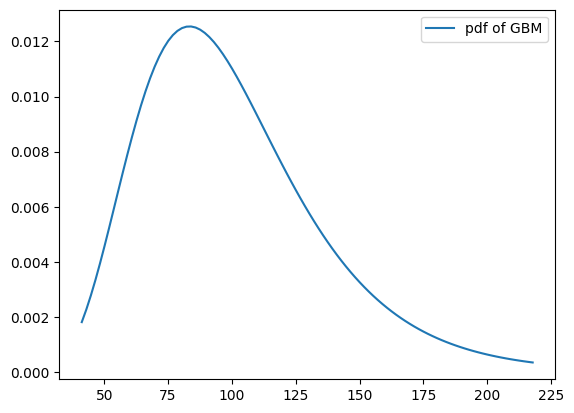

The mean of GBM is 101.00501670841683 and the standard deviation is 37.324463336559596
 99% of the mass of the distribution is between 41.21781922368857 and 217.77658627668333


In [212]:
K, S0, r, T, I_market = 80, 100, 0.05, 0.2, 22
sigma = 0.8

mu_N = np.log(S0) + (r-0.5*sigma**2) * T
sd_N = np.sqrt( sigma ** 2 * T)

x = np.linspace(st.lognorm.ppf(0.01, scale = np.exp(mu_N), s = sd_N),st.lognorm.ppf(0.99, scale = np.exp(mu_N), s = sd_N),100)
z = st.lognorm.pdf(x, scale = np.exp(mu_N), s = sd_N)
z2 = np.zeros(shape=(len(x)))
z2 = np.exp(-r*T) * np.maximum( 0,(K - x) )

plt.plot(x,z, label = "pdf of GBM")

plt.legend()
plt.show()
print(f"The mean of GBM is { np.exp( mu_N + (sd_N**2) / 2)} and the standard deviation is { np.sqrt( (np.exp(sd_N ** 2) - 1) * np.exp(2 * mu_N + sd_N ** 2) )}")
print(f" 99% of the mass of the distribution is between {st.lognorm.ppf(0.01, scale = np.exp(mu_N), s = sd_N)} and {st.lognorm.ppf(0.99, scale = np.exp(mu_N), s = sd_N)}")

In [213]:
alpha = 0.05

q = st.lognorm.ppf(1-alpha, scale = np.exp(mu_N), s = sd_N)
print(f" There is a {alpha} probability that the GBM is bigger than {q} with r = {r}")

r_tilde = -3.7

mu_N_tilde = np.log(S0) + (r_tilde-0.5*sigma**2) * T

q = st.lognorm.ppf(1-alpha, scale = np.exp(mu_N_tilde), s = sd_N)
print(f" There is a {alpha} probability that the GBM is bigger than {q} with r_tilde = {r_tilde}")  

 There is a 0.05 probability that the GBM is bigger than 170.6561834952307 with r = 0.05
 There is a 0.05 probability that the GBM is bigger than 80.61227310158017 with r_tilde = -3.7


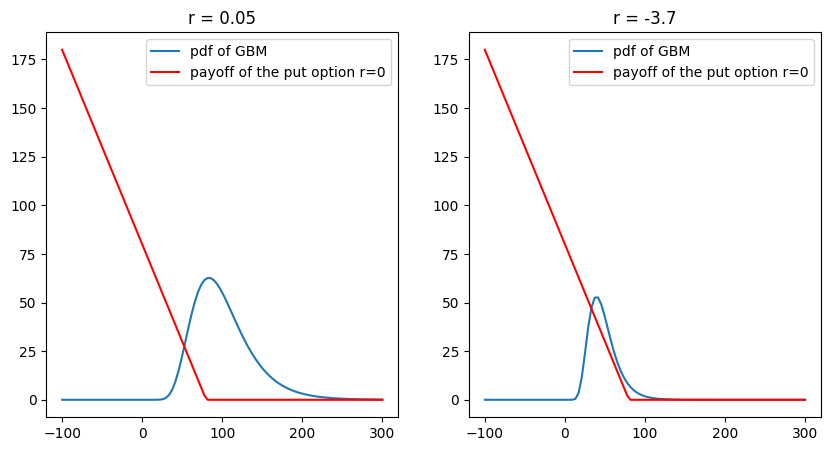

In [214]:
x = np.linspace(-100,300,100)
y = np.maximum( 0,(K - x) )

fig, axes = plt.subplots(1,2,figsize=(10, 5))

z = 5000 * st.lognorm.pdf(x, scale = np.exp(mu_N), s = sd_N)
z_tilde = 2000 * st.lognorm.pdf(x, scale = np.exp(mu_N_tilde), s = sd_N)

axes[0].plot(x,z, label = "pdf of GBM")
axes[0].plot(x,y, label = "payoff of the put option r=0", color= "red")
axes[0].legend()
axes[0].set_title("r = 0.05")

axes[1].plot(x,z_tilde, label = "pdf of GBM")
axes[1].plot(x,y, label = "payoff of the put option r=0", color= "red")
axes[1].legend()
axes[1].set_title(f"r = {r_tilde}")

plt.legend()
plt.show()

How the distribution of the lognormal changes with r:

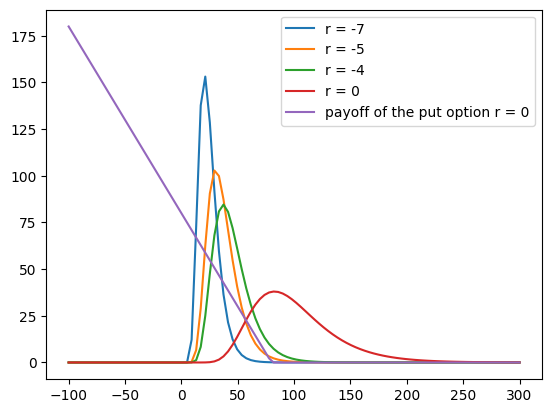

In [215]:
r_values = [-7,-5,-3-1,0]

for i in range(len(r_values)):

    mu_N = np.log(S0) + (r_values[i]-0.5*sigma**2) * T

    z = 3000 *st.lognorm.pdf(x, scale = np.exp(mu_N), s = sd_N)
    z2 = np.maximum( 0,(K - x) )

    plt.plot(x,z, label = f"r = {r_values[i]}")


plt.plot(x,y, label = f"payoff of the put option r = 0")
plt.legend()
plt.show()

Actually I want to approximate f(x)*p(x)

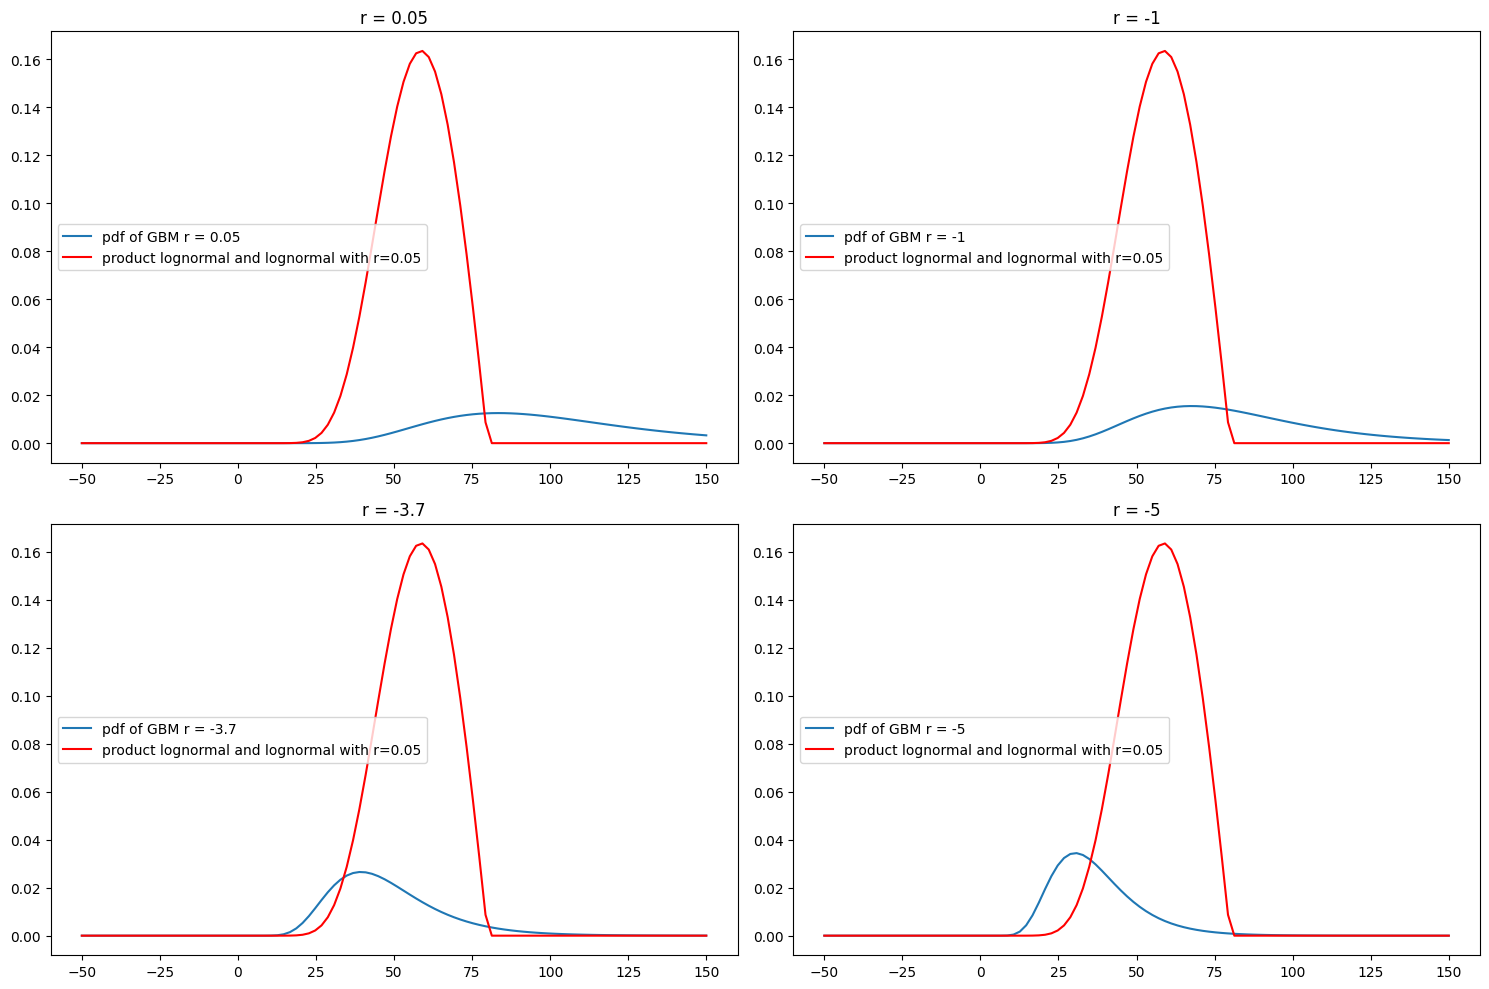

In [265]:
K, S0, r, T, I_market = 80, 100, 0.05, 0.2, 22
sigma = 0.8

x = np.linspace(-50,150,100)
y = np.exp(-r*T)*np.maximum( 0,(K - x) )

mu_N = np.log(S0) + (r-0.5*sigma**2) * T
z = st.lognorm.pdf(x, scale = np.exp(mu_N), s = sd_N) 
g = z * y 

r_values = [0.05,-1,-3.7,-5,]

fig, axes = plt.subplots(2,2,figsize=(15, 10))

for i, r in enumerate(r_values):
    mu_N_tilde = np.log(S0) + (r-0.5*sigma**2) * T
    z_tilde = st.lognorm.pdf(x, scale = np.exp(mu_N_tilde), s = sd_N)

    axes[i//2,i%2].plot(x,z_tilde, label = f"pdf of GBM r = {r}")
    axes[i//2,i%2].plot(x,g, label = f"product lognormal and lognormal with r=0.05", color= "red")
    axes[i//2,i%2].legend()
    axes[i//2,i%2].set_title(f"r = {r_values[i]}")

plt.tight_layout()

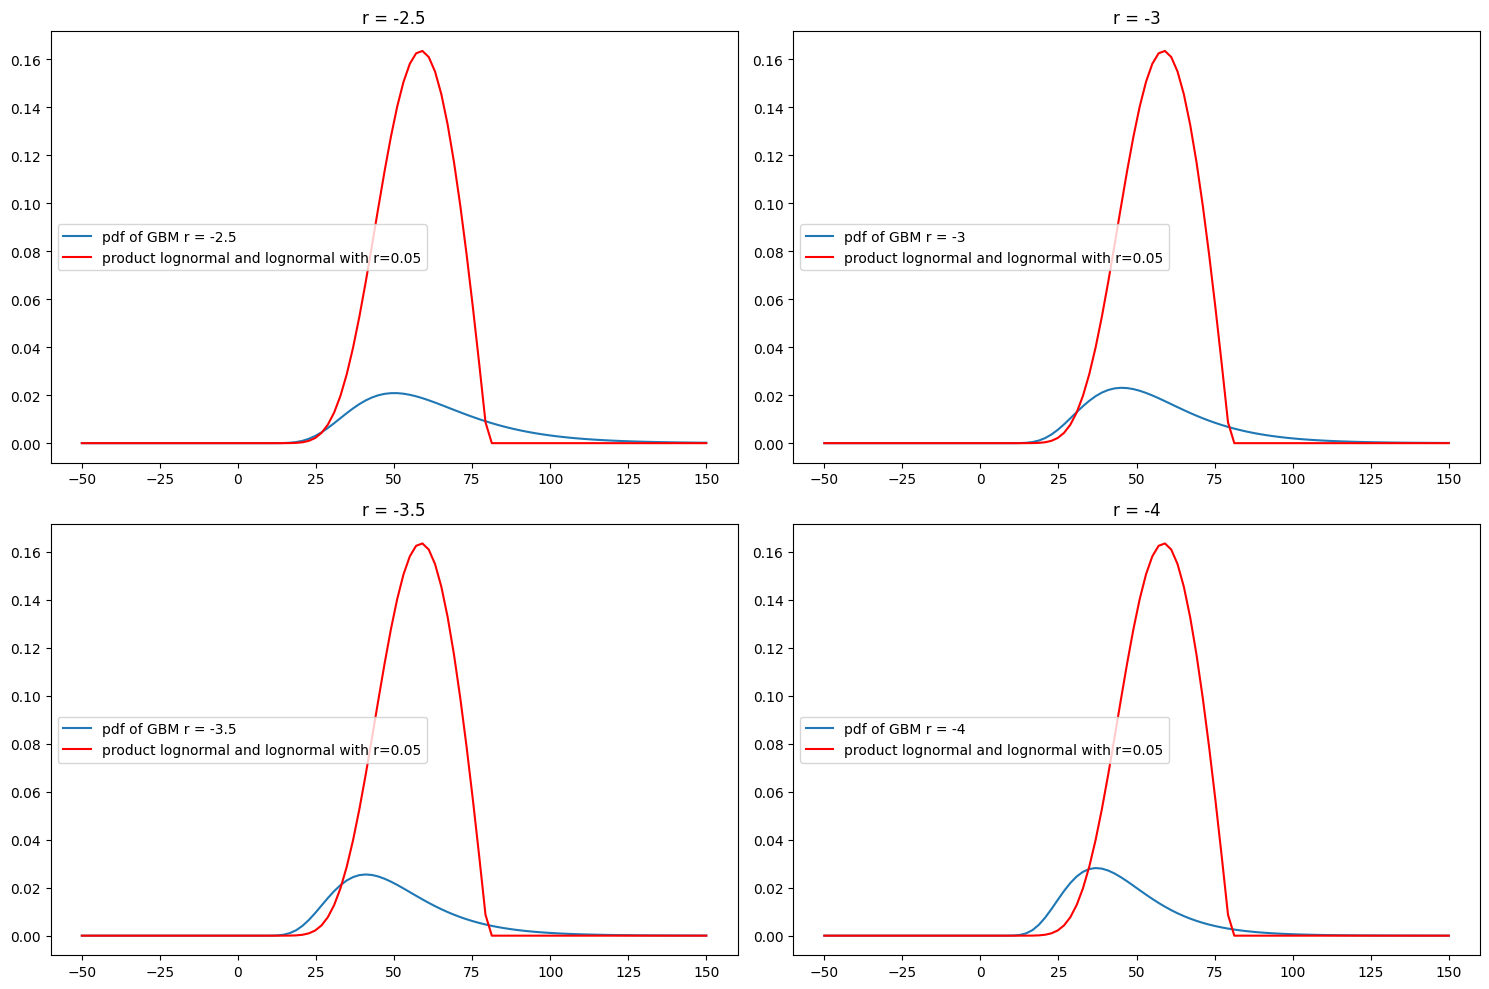

In [337]:
K, S0, r, T, I_market = 80, 100, 0.05, 0.2, 22
sigma = 0.8

x = np.linspace(-50,150,100)
y = np.exp(-r*T)*np.maximum( 0,(K - x) )

mu_N = np.log(S0) + (r-0.5*sigma**2) * T
z = st.lognorm.pdf(x, scale = np.exp(mu_N), s = sd_N) 
g = z * y 

r_values = [-2.5,-3,-3.5,-4]

fig, axes = plt.subplots(2,2,figsize=(15, 10))

for i, r in enumerate(r_values):
    mu_N_tilde = np.log(S0) + (r-0.5*sigma**2) * T
    z_tilde = st.lognorm.pdf(x, scale = np.exp(mu_N_tilde), s = sd_N)

    axes[i//2,i%2].plot(x,z_tilde, label = f"pdf of GBM r = {r}")
    axes[i//2,i%2].plot(x,g, label = f"product lognormal and lognormal with r=0.05", color= "red")
    axes[i//2,i%2].legend()
    axes[i//2,i%2].set_title(f"r = {r_values[i]}")

plt.tight_layout()

Let us compute the mean value of our geometric brownian path

In [372]:
K, S0, r, T, I_market = 80, 100, 0.05, 0.2, 22
sigma = 0.8
m = 50
Q=[]

for i in range(1,51):
    Q = np.append(Q,S0 * np.exp( (r-sigma**2/2) * T/m * i * (i-1) / 2 ))

mu_path = np.mean(Q)
print(f"The mean of the path is {mu_path}")

mu_N = np.log(mu_path) + (r-0.5*sigma**2) * T
sd_N = np.sqrt( sigma ** 2 * T)

print(f"The mean of GBM is { np.exp( mu_N + (sd_N**2) / 2)}")
print(f" 99% of the mass of the distribution is between {st.lognorm.ppf(0.01, scale = np.exp(mu_N), s = sd_N)} and {st.lognorm.ppf(0.99, scale = np.exp(mu_N), s = sd_N)}")


The mean of the path is 68.63071133315138
The mean of GBM is 69.32046144915488
 99% of the mass of the distribution is between 28.288082529229882 and 149.46162027874192


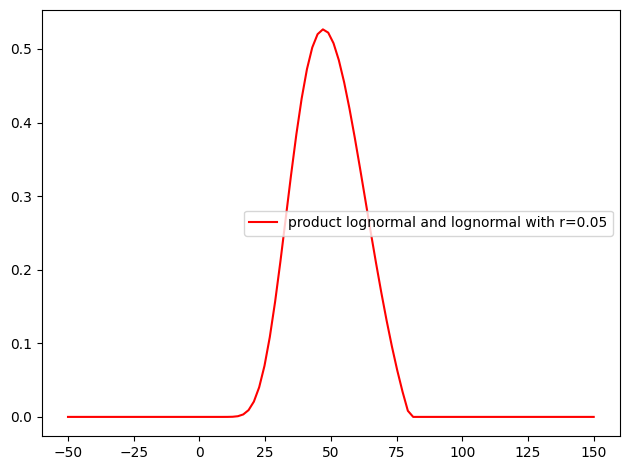

The mean of g is 47.139471394713944


In [385]:
x = np.linspace(-50,150,100)
y = np.exp(-r*T)*np.maximum( 0,(K - x) )
z = st.lognorm.pdf(x, scale = np.exp(mu_N), s = sd_N) 
g = z * y 

plt.plot(x,g, label = f"product lognormal and lognormal with r=0.05", color= "red")
plt.legend()
plt.tight_layout()
plt.show()

# Retrieve the max of f * p, which is in between 0 and 100 and it is the mean of this new pdf called g
x = np.linspace(0,100,100000)
y = np.exp(-r*T)*np.maximum( 0,(K - x) )

z = st.lognorm.pdf(x, scale = np.exp(mu_N), s = sd_N) 
g = z * y 

mu_g = x[np.argmax(g)]
print(f"The mean of g is {mu_g}")

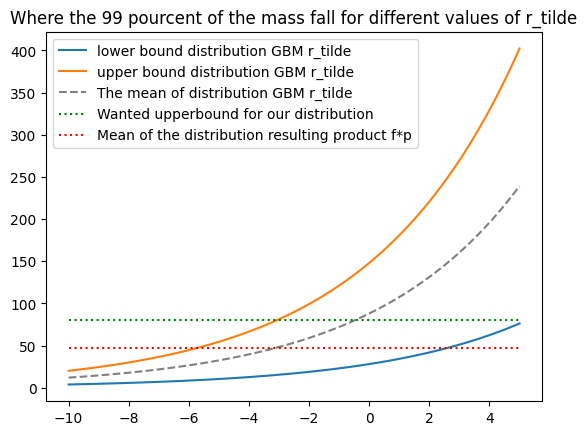

In [424]:
r = np.linspace(-10,5,100)
sd_N = np.sqrt( sigma ** 2 * T)
y1 = []
y2 = []
ligne_k = np.full(100,K)
ligne_mu_g = np.full(100,mu_g)
for i in range(100):

    mu_N = np.log(mu_path) + (r[i]-0.5*sigma**2) * T
    y1 = np.append(y1,st.lognorm.ppf(0.01, scale = np.exp(mu_N), s = sd_N))
    y2 = np.append(y2,st.lognorm.ppf(0.99, scale = np.exp(mu_N), s = sd_N))

y3 = (y1+y2)/2
plt.plot(r,y1, label = "lower bound distribution GBM r_tilde")
plt.plot(r,y2, label = "upper bound distribution GBM r_tilde")
plt.plot(r,y3, label = "The mean of distribution GBM r_tilde", color="grey",linestyle='--')
plt.plot(r,ligne_k, label = "Wanted upperbound for our distribution",color="green",linestyle='dotted')
plt.plot(r,ligne_mu_g, label = "Mean of the distribution resulting product f*p",color="red",linestyle='dotted')
plt.title("Where the 99 pourcent of the mass fall for different values of r_tilde")
plt.legend()
plt.show()

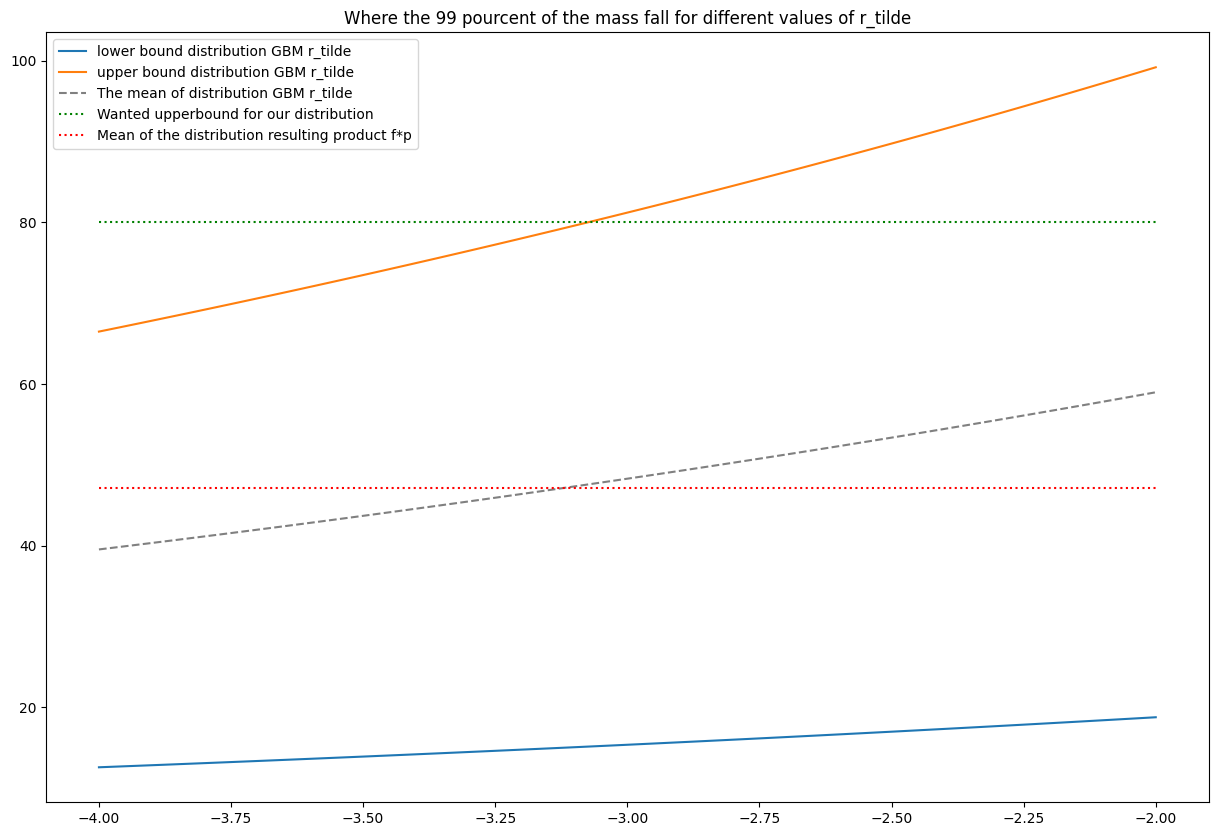

In [425]:
r = np.linspace(-4,-2,100)
sd_N = np.sqrt( sigma ** 2 * T)
y1 = []
y2 = []
ligne_k = np.full(100,K)
ligne_mu_g = np.full(100,mu_g)
for i in range(100):

    mu_N = np.log(mu_path) + (r[i]-0.5*sigma**2) * T
    y1 = np.append(y1,st.lognorm.ppf(0.01, scale = np.exp(mu_N), s = sd_N))
    y2 = np.append(y2,st.lognorm.ppf(0.99, scale = np.exp(mu_N), s = sd_N))

y3 = (y1+y2)/2
plt.figure(figsize=(15,10))
plt.plot(r,y1, label = "lower bound distribution GBM r_tilde")
plt.plot(r,y2, label = "upper bound distribution GBM r_tilde")
plt.plot(r,y3, label = "The mean of distribution GBM r_tilde", color="grey",linestyle='--')
plt.plot(r,ligne_k, label = "Wanted upperbound for our distribution",color="green",linestyle='dotted')
plt.plot(r,ligne_mu_g, label = "Mean of the distribution resulting product f*p",color="red",linestyle='dotted')
plt.title("Where the 99 pourcent of the mass fall for different values of r_tilde")
plt.legend()
plt.show()

Back to exercise

In [426]:
# Part a) Use IS to approximate I(sigma). Note: Jhat(sigma) = Ihat(sigma) - I_market

# Calculate likelihood ratio
def w(S_T, S_0, sigma, r, r_tilde, T):
    return (S_T/S_0)**((r - r_tilde)/sigma**2) * np.exp((r+r_tilde-sigma**2)*(-r+r_tilde)*T/(2*sigma**2))

def RM_Asian_with_IS(n, N, rho, K, S0, T, r, r_tilde, I_market, m, sigma_0 = 1):
    alpha_0 = 2/(K+S0)

    sigma_estim = np.empty((n,))
    sigma_estim[0] = sigma_0
    
    for i in range(1, n):
        alpha_n = alpha_0 / i ** rho
        sigma_cur = sigma_estim[i - 1]

        # Calculate Jhat with IS
        simulations = Simulate_Stock_Price(S0, sigma_cur, r_tilde, T, m, N)
        likelihood_ratios = w(simulations[:, -1], S0, sigma_cur, r, r_tilde, T)
        avg_stock_prices = np.mean(simulations, axis=1)
        payoffs = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0)
        Jhat = np.mean(np.multiply(payoffs, likelihood_ratios)) - I_market

        sigma_estim[i] = sigma_cur - alpha_n * Jhat

    return sigma_estim

NameError: name 'RM_Asian' is not defined

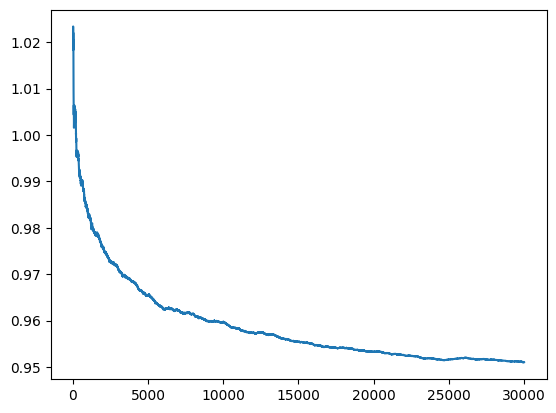

In [427]:
n, N, rho = 30000, 10, 0.8
K, S0, T, r, I_market = 80, 100, 0.2, 0.05, 2
r_tilde = 10**-6
m = 30

sigmas_IS = RM_Asian_with_IS(n, N, rho, K, S0, T, r, r_tilde, I_market, m)
plt.plot(range(21,n+1), sigmas_IS[20:], label="with IS")

sigmas = RM_Asian(n, N, rho, K, S0, T, r, I_market, m)
plt.plot(range(21,n+1), sigmas[20:], label="without IS")

plt.xlabel('n')
plt.ylabel('sigma')
plt.legend()

In [ ]:
# Question 7
from scipy.optimize import minimize_scalar

K, S0, T, r = 80, 100, 0.2, 0.05
m = 30
N = 100
def find_optimal_r_tilde(sigmas, S0, K, r, T, m, N):
    def g(eta, sigma, simulations):
        likelihood_ratios = w(simulations[:, -1], S0, sigma, r, eta, T)
        
        avg_stock_prices = np.mean(simulations[:, 1:], axis=1)
        payoffs_squared = (np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0))**2
        variance = np.mean(np.multiply(payoffs_squared, likelihood_ratios))
        return variance
    
    if type(sigmas) == float:
        simulations = Simulate_Stock_Price(S0, sigma, r, T, m, N)
        return minimize_scalar(g, args=(sigmas,simulations), bounds = (0, 1)).x
    else:
        result = {}
        for sigma in sigmas:
            simulations = Simulate_Stock_Price(S0, sigma, r, T, m, N)
            result[sigma] = minimize_scalar(g, args=(sigma,simulations), bounds = (0, 1)).x

        return result
sigmas = np.linspace(0.3, 5, num=1000)
result = find_optimal_r_tilde(sigmas, S0, K, r, T, m, N)
print(result)

{0.3: 0.9999940391390134, 0.3047047047047047: 4.053349035892279e-06, 0.3094094094094094: 0.9999940391390134, 0.3141141141141141: 0.9999940391390134, 0.3188188188188188: 0.9999940391390134, 0.32352352352352354: 3.886417458363482e-06, 0.3282282282282282: 3.407834306590374e-06, 0.3329329329329329: 3.475145347567674e-06, 0.33763763763763766: 4.089108502423367e-06, 0.34234234234234234: 0.9999940391390134, 0.34704704704704703: 0.9999940391390134, 0.3517517517517518: 0.9999940391390134, 0.35645645645645646: 5.735157473386274e-06, 0.36116116116116115: 3.7621961747660863e-06, 0.3658658658658659: 0.9999940391390134, 0.3705705705705706: 0.9999940391390134, 0.37527527527527527: 4.482145974429293e-06, 0.37997997997997995: 4.8443598223780375e-06, 0.38468468468468464: 6.644965291640485e-06, 0.3893893893893894: 4.283915299872466e-06, 0.39409409409409407: 5.504458261216802e-06, 0.39879879879879876: 4.5487157770817075e-06, 0.4035035035035035: 3.668720812622367e-06, 0.4082082082082082: 5.514556211439587e

In [ ]:
def RM_Asian_with_IS_opt(n, N, rho, K, S0, T, r, I_market, m, sigma_0=1):
    alpha_0 = 2/(K+S0)

    sigma_estim = np.empty((n,))
    sigma_estim[0] = sigma_0
    
    for i in range(1, n):
        alpha_n = alpha_0 / i ** rho
        sigma_cur = sigma_estim[i - 1]

        # Calculate Jhat with IS
        r_tilde = result[min(result, key=lambda x : abs(x - sigma_cur))]
        simulations = Simulate_Stock_Price(S0, sigma_cur, r_tilde, T, m, N)
        likelihood_ratios = w(simulations[:, -1], S0, sigma_cur, r, r_tilde, T)
        avg_stock_prices = np.mean(simulations, axis=1)
        payoffs = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0)
        Jhat = np.mean(np.multiply(payoffs, likelihood_ratios)) - I_market

        sigma_estim[i] = sigma_cur - alpha_n * Jhat

    return sigma_estim

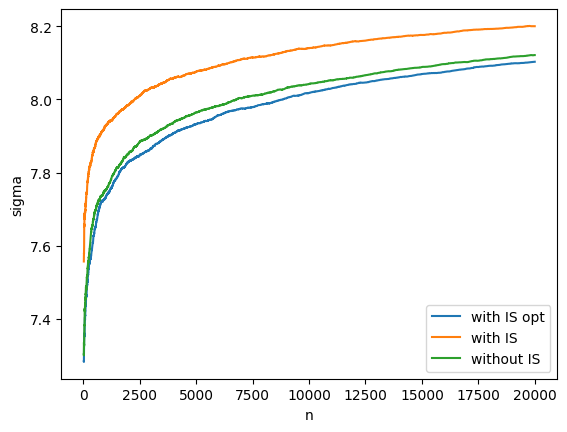

In [ ]:
n, N, rho = 20000, 10, 0.8
K, S0, T, r, I_market = 80, 100, 0.2, 0.05, 50
r_tilde = 10**-6
m = 30

sigmas_IS = RM_Asian_with_IS_opt(n, N, rho, K, S0, T, r, I_market, m, sigma_0=7)
plt.plot(range(21,n+1), sigmas_IS[20:], label="with IS opt")

sigmas_IS = RM_Asian_with_IS(n, N, rho, K, S0, T, r, r_tilde, I_market, m, sigma_0=7)
plt.plot(range(21,n+1), sigmas_IS[20:], label="with IS")

sigmas = RM_Asian(n, N, rho, K, S0, T, r, I_market, m, sigma_0=7)
plt.plot(range(21,n+1), sigmas[20:], label="without IS")

plt.xlabel('n')
plt.ylabel('sigma')
plt.legend()